# Taxi Price Prediction Using Regression Technique 
## Objective
The goal of this analysis is to predict taxi trip fares based on various features, such as trip distance, duration, time of day, and traffic conditions. The dataset has been processed, analyzed, and used to train several regression models.

![alt text](local-taxi.jpg)



# IMPORTING LIBRARIES

In [2]:
# imports
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso


# LOAD DATA

In [3]:
taxi_data = pd.read_csv("taxi_trip_pricing.csv")
taxi_data.head(10) # View first 

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180
5,8.64,Afternoon,Weekend,2.0,Medium,Clear,2.55,1.71,0.48,89.33,60.2028
6,3.85,Afternoon,Weekday,4.0,High,Rain,3.51,1.66,NaN,5.05,11.2645
7,43.44,Evening,Weekend,3.0,NaN,Clear,2.97,1.87,0.23,NaN,101.1216
8,30.45,Morning,Weekday,3.0,High,Clear,2.77,1.78,0.34,110.33,NaN
9,35.70,Afternoon,Weekday,2.0,Low,Rain,3.39,1.52,0.47,NaN,75.5657


In [4]:
# Check The Shape of The Data
taxi_data.shape

(1000, 11)

In [5]:
# Get a summary of the data types and missing values
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


# Data Cleaning

In [6]:
# Check for missing values
taxi_data.isnull().sum() 

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

### Handling Missing Values

The dataset contains some missing values. To address these, the data is split into two subsets: **numerical columns** and **categorical columns**, with different imputation strategies applied to each subset.

### 1. Numerical Columns
- **Imputation Strategy**: Missing values in numerical columns are replaced with the **median** of each column.
- **Reason**:
  - The median is robust to outliers and provides a more accurate central tendency for numerical data compared to the mean.

### 2. Categorical Columns
- **Imputation Strategy**: Missing values in categorical columns are replaced with the **mode** of each column (the most frequently occurring value).
- **Reason**:
  - The mode represents the most common category and helps maintain the integrity of categorical distributions.



### Fill missing values in numerical columns with the median

In [7]:
# Fill missing values in numerical columns with the median
numerical_columns = ['Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 
                     'Trip_Duration_Minutes', 'Trip_Price', 'Passenger_Count']
for column in numerical_columns:
    taxi_data[column].fillna(taxi_data[column].median(), inplace=True)

### Fill missing values in categorical columns with the mode

In [8]:
# Fill missing values in categorical columns with the mode
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']
for column in categorical_columns:
    taxi_data[column].fillna(taxi_data[column].mode()[0], inplace=True)

In [9]:
# Verify that all missing values are handled
print("Missing values after cleaning:\n", taxi_data.isnull().sum())

Missing values after cleaning:
 Trip_Distance_km         0
Time_of_Day              0
Day_of_Week              0
Passenger_Count          0
Traffic_Conditions       0
Weather                  0
Base_Fare                0
Per_Km_Rate              0
Per_Minute_Rate          0
Trip_Duration_Minutes    0
Trip_Price               0
dtype: int64


In [11]:
# Check For Duplicate Values Just Incase
taxi_data.duplicated().sum()

0

# Exploratory Data Analysis

In [12]:
# Summary Statistics
taxi_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Trip_Distance_km,1000.0,27.00852,19.402661,1.2300,13.10750,25.8300,37.78250,146.067047
Passenger_Count,1000.0,2.45300,1.079331,1.0000,2.00000,2.0000,3.00000,4.000000
Base_Fare,1000.0,3.50384,0.848115,2.0100,2.77000,3.5200,4.20250,5.000000
Per_Km_Rate,1000.0,1.23265,0.418932,0.5000,0.87000,1.2200,1.58000,2.000000
Per_Minute_Rate,1000.0,0.29277,0.112664,0.1000,0.19750,0.2900,0.38250,0.500000
Trip_Duration_Minutes,1000.0,62.10521,31.339464,5.0100,37.10750,61.8600,87.77500,119.840000
Trip_Price,1000.0,56.54156,39.492129,6.1269,34.57885,50.0745,67.47665,332.043689


### Checking and Capping outliers

In [15]:
# identifying outliers
print("Identifying Outliers:")

for col in numerical_columns:
    Q1 = taxi_data[col].quantile(0.25)
    Q3 = taxi_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = taxi_data[(taxi_data[col] < lower_bound) | (taxi_data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(taxi_data)*100:.2f}%)")


# we will use the IQR method. After calculations, we can see that we only have outliers in Trip_Distance_km. 
# The count is 20 which is 2%, so we can just drop them.

Identifying Outliers:
Trip_Distance_km: 20 outliers (2.00%)
Base_Fare: 0 outliers (0.00%)
Per_Km_Rate: 0 outliers (0.00%)
Per_Minute_Rate: 0 outliers (0.00%)
Trip_Duration_Minutes: 0 outliers (0.00%)
Trip_Price: 28 outliers (2.80%)
Passenger_Count: 0 outliers (0.00%)


In [16]:
# drop rows with outliers
for col in numerical_columns:
    Q1 = taxi_data[col].quantile(0.25)
    Q3 = taxi_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    is_outliers = (taxi_data[col] < lower_bound) | (taxi_data[col] > upper_bound)
    taxi_data = taxi_data[~is_outliers]

### Distribution for Trip_Price

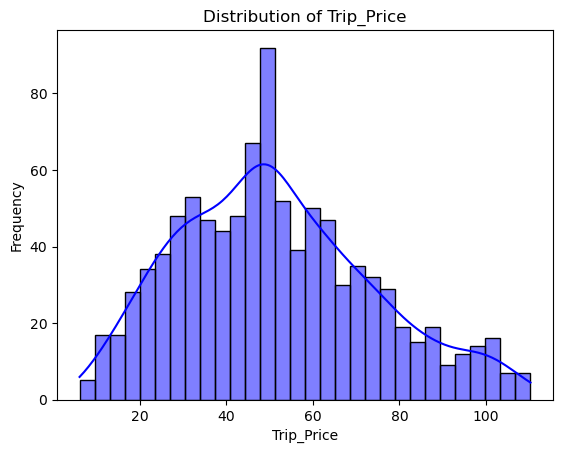

In [17]:
#Visualize the distribution of Trip_Price
plt.Figure(figsize=(8,6))
sns.histplot(taxi_data['Trip_Price'], kde=True, bins=30, color='blue')
plt.title("Distribution of Trip_Price")
plt.xlabel("Trip_Price")
plt.ylabel("Frequency")
plt.show()

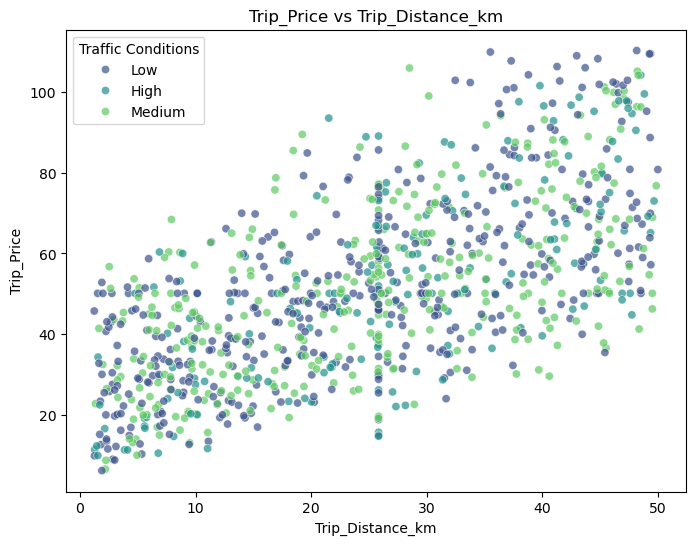

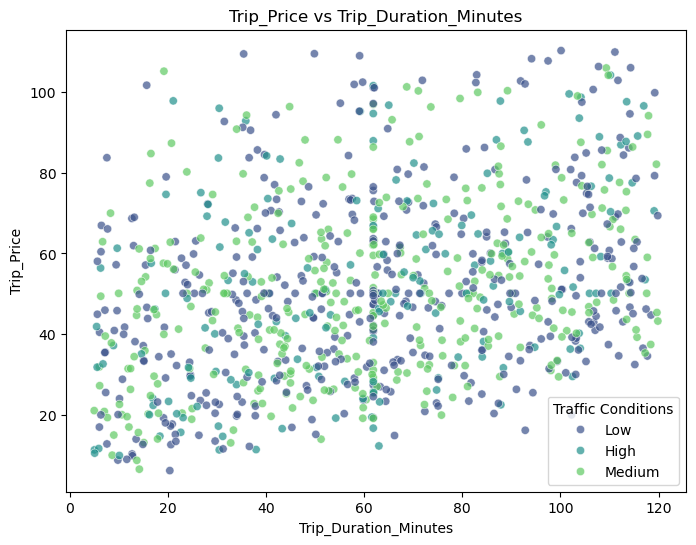

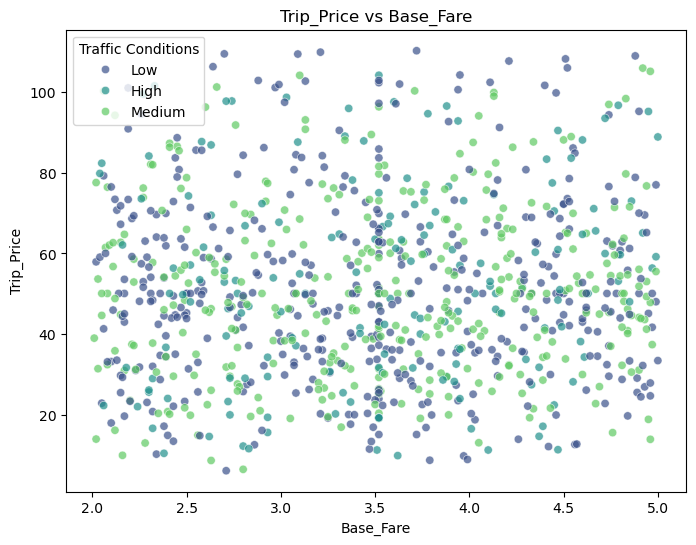

In [18]:
# Visualize relationships between Trip_Price and key features
features_to_plot = ['Trip_Distance_km', 'Trip_Duration_Minutes', 'Base_Fare']

for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=taxi_data, x=feature, y='Trip_Price', hue='Traffic_Conditions', palette='viridis', alpha=0.7)
    plt.title(f"Trip_Price vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Trip_Price")
    plt.legend(title="Traffic Conditions")
    plt.show()

### Boxplot 

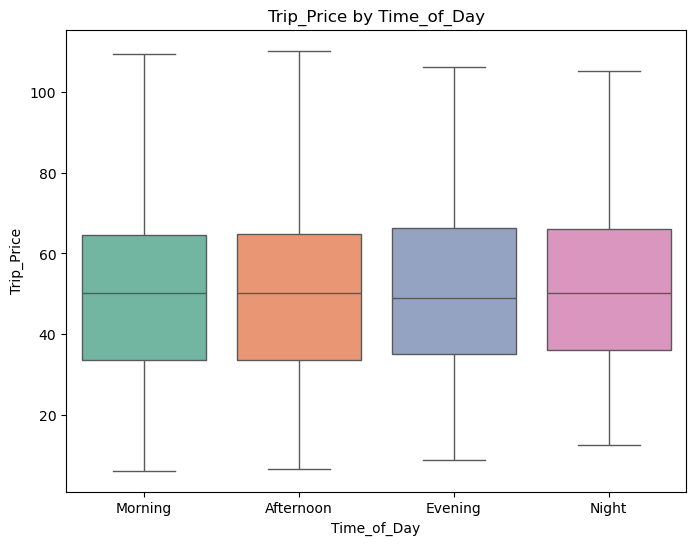

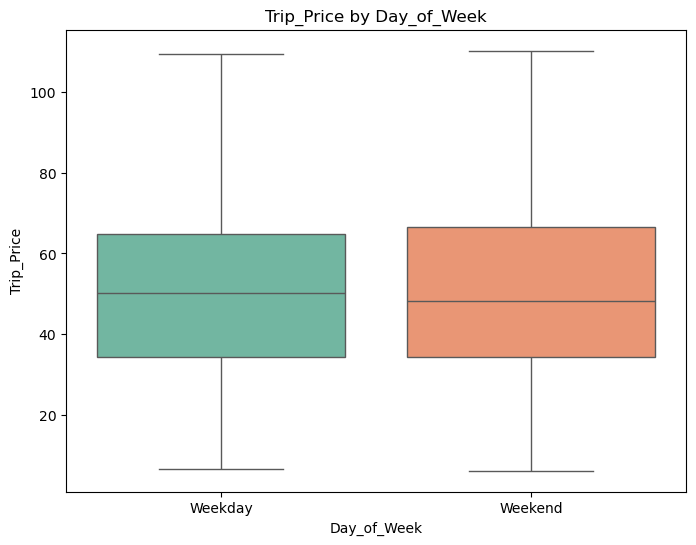

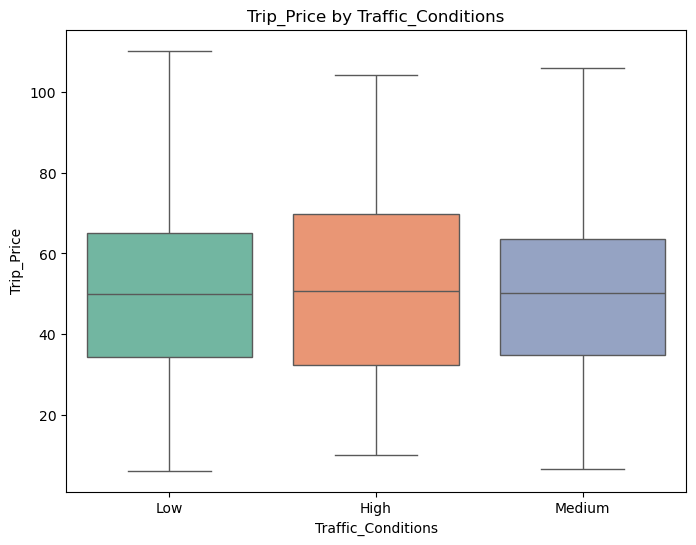

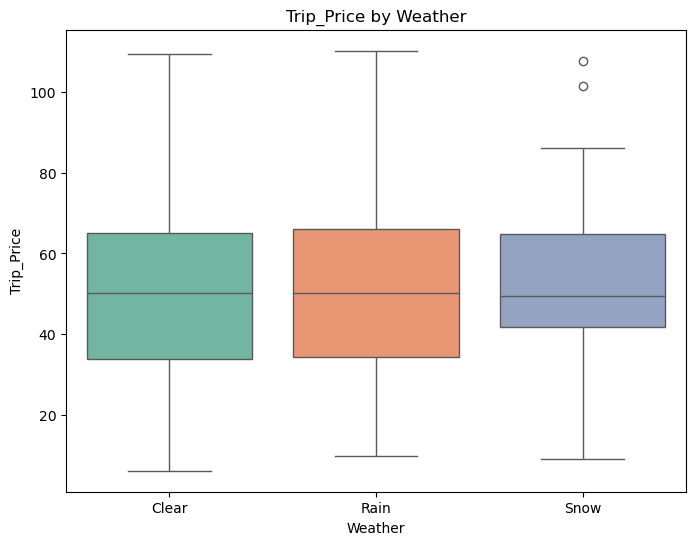

In [19]:
# Boxplot for categorical features and Trip_Price
categorical_features = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=taxi_data, x=feature, y='Trip_Price', palette='Set2')
    plt.title(f"Trip_Price by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Trip_Price")
    plt.show()

### Correlation Analysis

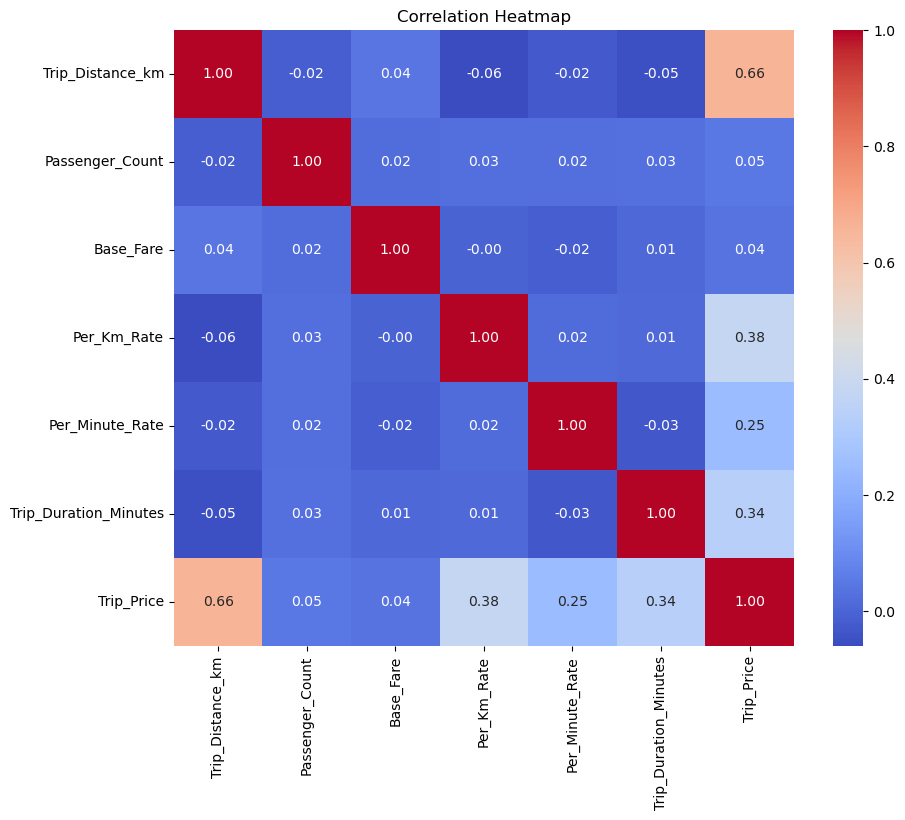

In [20]:
# Select only numeric columns
numerical_columns = taxi_data.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Visualize the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


### Feature Engineering 

In [24]:
# Feature Engineering Ideas
print("Feature Engineering Suggestions")


# 1. Price_Per_Minute: Calculated by dividing total trip price by duration, this metric helps identify time-based pricing variations and potential surge pricing periods.

# 2. Price_Per_Km: Obtained by dividing total price by distance traveled, revealing distance-based rate changes and helping detect pricing anomalies across different routes.

# 3. Is_Rush_Hour: Binary flag set to 1 during morning and evening peaks (typically associated with higher demand), enabling the model to capture rush hour pricing effects.


# Create price per minute
taxi_data['Price_Per_Minute'] = taxi_data['Trip_Price'] / taxi_data['Trip_Duration_Minutes']

# Create price per km
taxi_data['Price_Per_Km'] = taxi_data['Trip_Price'] / taxi_data['Trip_Distance_km']

# Rush hour flag (Evening and Morning)
taxi_data['Is_Rush_Hour'] = taxi_data['Time_of_Day'].isin(['Morning', 'Evening']).astype(int)

# Show summary of new features
print("New feature statistics:")
print(taxi_data[['Price_Per_Minute', 'Price_Per_Km', 'Is_Rush_Hour']].describe())

Feature Engineering Suggestions
New feature statistics:
       Price_Per_Minute  Price_Per_Km  Is_Rush_Hour
count        970.000000    970.000000    970.000000
mean           1.205912      3.064803      0.486598
std            1.279286      3.321027      0.500078
min            0.173681      0.567600      0.000000
25%            0.561846      1.559699      0.000000
50%            0.806923      2.145022      0.000000
75%            1.266757      3.028406      1.000000
max           11.027207     37.146504      1.000000


## Separating Dependent and Independent Variable

In [25]:
# Splitting the Data
X = taxi_data.drop(columns=['Trip_Price'])
y = taxi_data['Trip_Price']

### Apply One-Hot Encoding

In [26]:
# One-Hot Encoding using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

In [27]:
# Transform features
X_encoded = preprocessor.fit_transform(X)

In [28]:
# Convert encoded features into a DataFrame for better interpretability
encoded_feature_names = preprocessor.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

### Scaling the Data

In [29]:
#  Scaling the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_encoded_df)

**Split train and test Set**

In [30]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)

# Model Building

In [32]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R^2": r2
    })

# Create a results DataFrame
results_df = pd.DataFrame(results)


In [33]:
# Display results
print("Model Evaluation Metrics:")
print(results_df)

Model Evaluation Metrics:
               Model      RMSE       MAE       R^2
0  Linear Regression  9.052745  7.022276  0.835877
1   Ridge Regression  9.024188  6.980004  0.836911
2   Lasso Regression  9.041168  7.002674  0.836297
3      Random Forest  2.566368  1.749008  0.986810


In [34]:
# Cross-validation for the best performing model - Random Forest
print("\nCross-Validation for Random Forest:")
cv_scores = cross_val_score(models["Random Forest"], X_train, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}")


Cross-Validation for Random Forest:
Cross-Validation R2 Scores: [0.97861151 0.98775805 0.97539303 0.96341735 0.98181968]
Mean CV Score: 0.9773999258918572


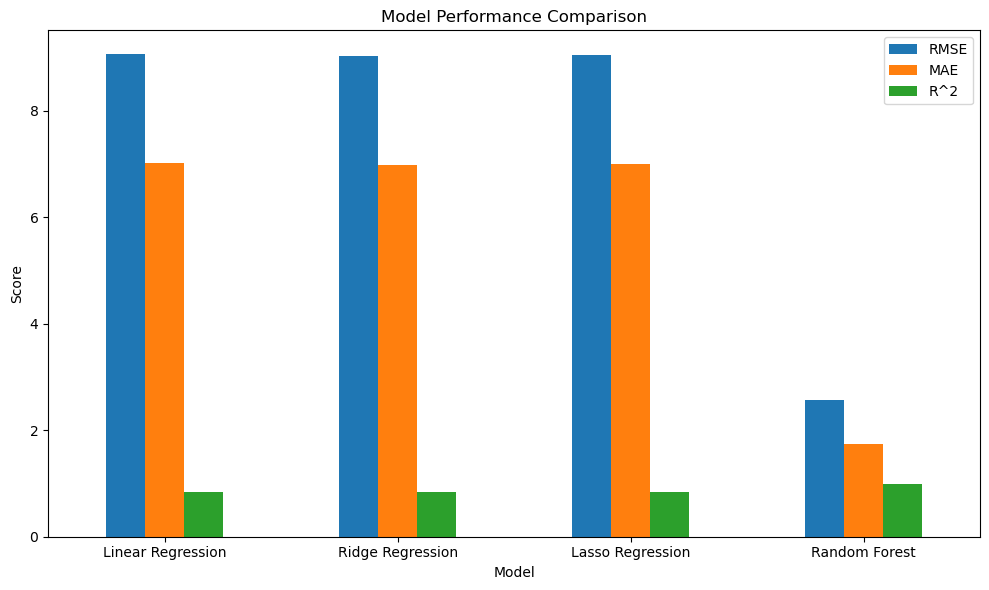

In [35]:
# Visualize Model Metrics
results_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

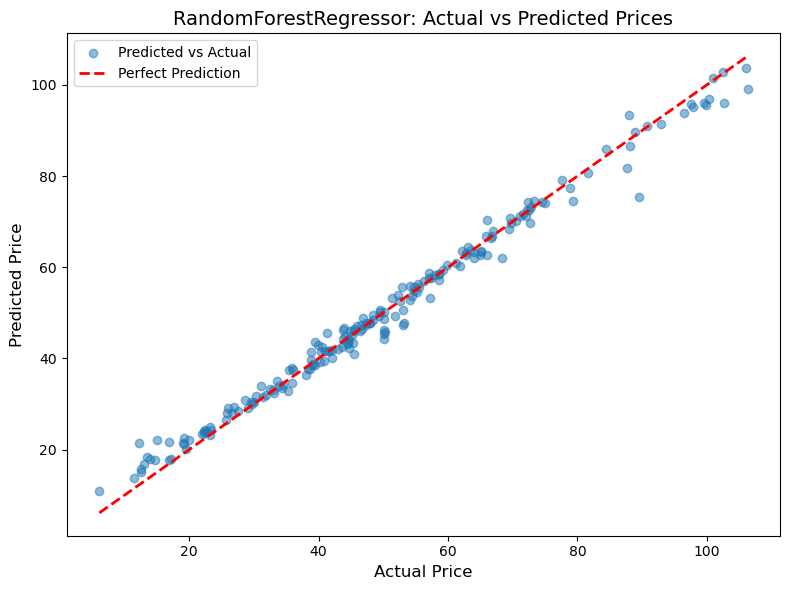

In [36]:
# Visualize predictions vs actual for Random Forest Regressor
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.title('RandomForestRegressor: Actual vs Predicted Prices', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion
The taxi fare prediction project successfully demonstrates the power of machine learning in solving real-world problems. By leveraging historical taxi trip data, we were able to build a robust predictive model capable of estimating fare amounts based on features such as trip distance, time of day, day of the week, and traffic conditions. 

The project involved key steps, including:
1. **Data Preprocessing**: Handling missing values, encoding categorical variables, and feature engineering to ensure the dataset was well-prepared for modeling.
2. **Exploratory Data Analysis**: Identifying trends and relationships in the data, such as the impact of distance and time of day on fares.
3. **Model Training and Evaluation**: Training multiple regression models (e.g., Linear Regression, Ridge Regression, Lasso Regression, and Random Forest), and cross-validation was done to check the robustness of the model before selecting the best-performing model.

The **Random Forest Regressor** emerged as the best-performing model, providing high accuracy and low error rates. This model forms the foundation for predicting trip fees that could significantly improve customer confidence and satisfaction by providing real-time fare estimates before a trip begins. Additionally, this could empower drivers with insights into route efficiency and expected fares, enhancing their overall productivity.

### Key Outcomes:
- Enhanced transparency for customers, reducing uncertainty and improving trust in the pricing system.
- A data-driven approach to fare calculation that considers multiple factors beyond just trip distance.
- A scalable model that can be expanded with additional features, such as weather conditions or real-time traffic data, to further improve accuracy.

### Future Work:
To further enhance the model and its applications, future steps could include:
- Integrating real-time traffic and weather data for dynamic pricing.
- Deploying the model into a live environment via a mobile app or web API.
- Expanding the dataset to include data from multiple cities for broader applicability.

This project highlights the practical applications of machine learning in the transportation industry and sets the stage for creating smarter, data-driven solutions that benefit both customers and service providers.

